In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torchvision import datasets, transforms 
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix


In [3]:
transform=transforms.ToTensor()

In [4]:
train_data=datasets.CIFAR10(root='C:\\Users\\DELL\\OneDrive\\Desktop', train=True, download=False, transform=transform)

In [5]:
test_data=datasets.CIFAR10(root='C:\\Users\\DELL\\OneDrive\\Desktop', train=False, download=False, transform=transform)

In [6]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: C:\Users\DELL\OneDrive\Desktop
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: C:\Users\DELL\OneDrive\Desktop
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
torch.manual_seed(101)
train_loader=DataLoader(train_data, batch_size=10, shuffle=True)
test_loader=DataLoader(test_data, batch_size=10, shuffle=False)

In [9]:
class_names=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [10]:
for images,labels in train_loader:
    break

In [11]:
labels

tensor([1, 5, 8, 1, 6, 1, 6, 3, 7, 9])

In [12]:
import matplotlib.pyplot as plt

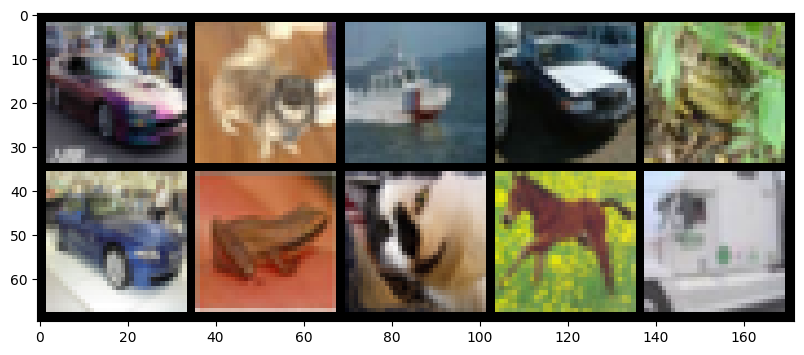

In [13]:
im=make_grid(images, nrow=5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

In [14]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,6,5,1) #(1,6,5,1) was when we had gray scale images. since the images are coloured here, we have to make it 3 instead of 1. 
        self.conv2=nn.Conv2d(6,16,3,1) #6 inputs, 16 arbitrary, 3*3 kernel size, 1 stride
        self.fc1=nn.Linear(6*6*16, 120) #we put 6*6*16 because after each convolutional layer, you lose two pixel and after each conv layer, we have a pooling layer 
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,6*6*16)
        X=F.relu(self.fc1(X))
        X=F.relu(self.fc2(X))
        X=self.fc3(X)
        return F.log_softmax(X, dim=1)

In [15]:
images[0].shape

torch.Size([3, 32, 32])

In [16]:
torch.manual_seed(101)
model=ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [17]:
for param in model.parameters():
    print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [18]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
import time
start_time=time.time()

epochs=1
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]

for i in range (epochs):
    trn_corr=0
    test_corr=0
    for b,(X_train, y_train) in enumerate(train_loader):
        b+=1
        y_pred=model(X_train) #no need to flatten here like ann because cnn accepts 2d data 
        loss=criterion(y_pred, y_train)
        
        predicted=torch.max(y_pred.data,1)[1]
        batch_corr=(predicted==y_train).sum()
        trn_corr+=batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (b%1000==0) :
            print(f"Epoch {i} Batch: {b} loss: {loss.item()}")
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    with torch.no_grad():
        for b,(X_test, y_test) in enumerate(test_loader):
            y_val=model(X_test)
            
            predicted=torch.max(y_val.data,1)[1]
            
            test_corr+=(predicted==y_test).sum()
            
    loss=criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(test_corr)

print(f"time taken is {time.time()-start_time:.0f} seconds")

Epoch 0 Batch: 1000 loss: 2.091362953186035
Epoch 0 Batch: 2000 loss: 1.8176498413085938
Epoch 0 Batch: 3000 loss: 0.9982473254203796
Epoch 0 Batch: 4000 loss: 1.1782933473587036
Epoch 0 Batch: 5000 loss: 1.4388775825500488
time taken is 517 seconds


In [21]:
torch.save(model.state_dict(), 'myCIFARmodel.pt')